# *fairlib*: A Unified Framework for Assessing and Improving Fairness

Xudong Han$^{1}$, &nbsp; Aili Shen$^{1,2, a}$, &nbsp; Yitong Li$^{3}$, &nbsp; Lea Frermann$^{1}$, &nbsp; Timothy Baldwin$^{1,4}$, &nbsp; and &nbsp; Trevor Cohn$^{1}$  

$^{1}$ The University of Melbourne

$^{2}$ Alexa AI, Amazon

$^{3}$ Huawei Technologies Co., Ltd.

$^{4}$ MBZUAI

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/e/ed/Logo_of_the_University_of_Melbourne.svg/330px-Logo_of_the_University_of_Melbourne.svg.png" height="100"/> &nbsp; &nbsp; &nbsp; &nbsp;
<img src="https://2019.emnlp.org/assets/images/logos/huawei-logo.png" height="100"/> &nbsp; &nbsp; &nbsp; &nbsp;
<img src="https://upload.wikimedia.org/wikipedia/en/5/55/Mohamed_bin_Zayed_University_of_Artificial_Intelligence_logo.png" height="100"/>

---
- $^a$ Work carried out at The University of Melbourne
- *fairlib* is licensed under the **Apache License 2.0**

[GitHub](https://github.com/HanXudong/fairlib), [Docs](https://hanxudong.github.io/fairlib/), [PyPI](https://pypi.org/project/fairlib/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HanXudong/fairlib/blob/main/tutorial/fairlib_demo.ipynb)

In this video, we will demostrate how to:
1.   Install *fairlib*
2.   Access fairness benchmark datasets
3.   Train a vanilla model without debiasing, and measure fairness
4.   Improve fairness with most recent debiasing methods
5.   Analyze the results, such as creating tables and figures

## 1. Installation

The most straightforward way to install *fairlib* is with pip:

In [1]:
!pip install -q fairlib

Check out *fairlib* [documents](https://hanxudong.github.io/fairlib/README.html) for other installation options. 

After installation, let's import *fairlib*.

In [2]:
import fairlib

## 2. Build a dataset

*fairlib* provides simple APIs to access fairness benchmark datasets that are publicly available and under strict ethical guidelines.

In this video, we will be using the preprocessed [Moji](https://github.com/shauli-ravfogel/nullspace_projection/blob/master/download_data.sh) dataset, where each tweet is annotated with a binary sentiment label (happy vs sad) and a binary race label (AAE vs SAE).
Original tweets are encoded with the pre-trained [DeepMoji model](https://github.com/bfelbo/DeepMoji) as 2304d vectors.

Followings are random examples from the Moji dataset.

| Text | Sentiment | Race |
| ---- | --------- | ---- |
| Dfl somebody said to me yesterday that how can u u have a iPhone or an S3 an ur phone off dfl | Positive | AAE|
| smh I bet maybe u just don't care bout poor boo no more | Negative | AAE |
| I actually put jeans on today and I already wanna go put on leggings or yogas | Positive | SAE |
| I'm sitting next to the most awkward couple on the plane like they are making out and holding hands , I just can't | Negative | SAE |

See [here](https://github.com/HanXudong/fairlib/tree/main/fairlib/datasets) for other avaliable datasets, including texts, images, and structured inputs.


In [3]:
from fairlib import datasets

In [4]:
datasets.prepare_dataset("moji", "data/deepmoji")

saving to /content/data/deepmoji/pos_pos.npy


  0%|          | 0/39 [00:00<?, ?it/s]

saving to /content/data/deepmoji/pos_neg.npy


  0%|          | 0/39 [00:00<?, ?it/s]

saving to /content/data/deepmoji/neg_pos.npy


  0%|          | 0/39 [00:00<?, ?it/s]

saving to /content/data/deepmoji/neg_neg.npy


  0%|          | 0/39 [00:00<?, ?it/s]

Datasets will be downloaded and saved to `data/deepmoji`, and then be used to create training, validation, and test splits as previous work.

In [5]:
datasets.name2class.keys()

dict_keys(['moji', 'bios', 'coloredmnist', 'compas', 'tp_pos', 'adult', 'coco', 'imsitu'])

## 3. Train a vanilla model without debiasing

### Specify hyperparameters

By default, *fairlib* trains `vanilla` models without debiasing. 

Here we specify the experiment id (`exp_id = vanilla`), which identify the directory for saving experimental results.

In [6]:
args = {
    # The name of the dataset, corresponding dataloader will be used,
    "dataset":  "Moji",

    # Specifiy the path to the input data
    "data_dir": "data/deepmoji",

    # Device for computing, -1 is the cpu; non-negative numbers indicate GPU id.
    "device_id":    -1,

    # Give a name to the exp, which will be used in the path
    "exp_id":"vanilla",
}

# Init the argument
options = fairlib.BaseOptions()
state = options.get_state(args=args, silence=True)

INFO:root:Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-8eb44448-ab67-4429-be7a-d5fc3fe3b2ce.json']
INFO:root:Logging to ./results/dev/Moji/vanilla/output.log


2022-07-21 06:53:09 [INFO ]  ======================================== 2022-07-21 06:53:09 ========================================
2022-07-21 06:53:09 [INFO ]  Base directory is ./results/dev/Moji/vanilla
Loaded data shapes: (99998, 2304), (99998,), (99998,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7998, 2304), (7998,), (7998,)


`state` contains a list of hyperparameters for experiments. Besides, other components that are needed, such as dataloaders, will also automatically be initialized 

### Initialize a model

The default architecutre is a 3-layer MLP classifier with Tanh activation functions in between: 

In [7]:
print(state.hidden_size, state.n_hidden, state.activation_function)

300 2 Tanh


Users can easily specify model architecutres in the option. 
Please see the [model architecture section](https://github.com/HanXudong/fairlib/blob/main/docs/usage.md#basic-operation) for more details about the hyperparameters corresponding to the model architecture.

In [8]:
fairlib.utils.seed_everything(2022)

# Init Model
model = fairlib.networks.get_main_model(state)

2022-07-21 06:53:10 [INFO ]  MLP( 
2022-07-21 06:53:10 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-07-21 06:53:10 [INFO ]    (AF): Tanh()
2022-07-21 06:53:10 [INFO ]    (hidden_layers): ModuleList(
2022-07-21 06:53:10 [INFO ]      (0): Linear(in_features=2304, out_features=300, bias=True)
2022-07-21 06:53:10 [INFO ]      (1): Tanh()
2022-07-21 06:53:10 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-07-21 06:53:10 [INFO ]      (3): Tanh()
2022-07-21 06:53:10 [INFO ]    )
2022-07-21 06:53:10 [INFO ]    (criterion): CrossEntropyLoss()
2022-07-21 06:53:10 [INFO ]  )
2022-07-21 06:53:10 [INFO ]  Total number of parameters: 782402 



### Train a model


A list of hyperparameters has been predefined in *fairlib*, so we can now directly train a model with the model class's built-in `train_self` method.

Please see the [link](https://github.com/HanXudong/fairlib/blob/23a32a6f4b3db00134bd651a6e0aa0747ba0adc2/fairlib/src/base_options.py#L162-L200) for all hyperparameters associated with model training.

In [9]:
model.train_self()

2022-07-21 06:53:10 [INFO ]  Epoch:    0 [      0/  99998 ( 0%)]	Loss: 0.6907	 Data Time: 0.06s	Train Time: 0.18s
2022-07-21 06:53:14 [INFO ]  Epoch:    0 [  51200/  99998 (51%)]	Loss: 0.4075	 Data Time: 0.44s	Train Time: 3.34s
2022-07-21 06:53:18 [INFO ]  Evaluation at Epoch 0
2022-07-21 06:53:18 [INFO ]  Validation accuracy: 71.44	macro_fscore: 71.35	micro_fscore: 71.44	TPR_GAP: 39.59	FPR_GAP: 39.59	PPR_GAP: 38.67	
2022-07-21 06:53:18 [INFO ]  Test accuracy: 71.21	macro_fscore: 71.12	micro_fscore: 71.21	TPR_GAP: 39.42	FPR_GAP: 39.42	PPR_GAP: 38.49	
2022-07-21 06:53:18 [INFO ]  Epoch:    1 [      0/  99998 ( 0%)]	Loss: 0.4195	 Data Time: 0.01s	Train Time: 0.07s
2022-07-21 06:53:22 [INFO ]  Epoch:    1 [  51200/  99998 (51%)]	Loss: 0.3780	 Data Time: 0.42s	Train Time: 3.29s
2022-07-21 06:53:26 [INFO ]  Evaluation at Epoch 1
2022-07-21 06:53:26 [INFO ]  Validation accuracy: 72.10	macro_fscore: 72.06	micro_fscore: 72.10	TPR_GAP: 37.69	FPR_GAP: 37.69	PPR_GAP: 37.00	
2022-07-21 06:53:26 [I

After each iteration, a subset of evaluation results over the validation set and test set will be logged, including metrics for both performance and fairness.

It can be seen that the vanilla model achieves around 40\% TPR GAP.

## 4. Improve Fairness

To mitigate bias, we show an example of employing BTEO ([Han et al., 2021a](https://arxiv.org/abs/2109.08253)) and adversarial training ([Li et al., 2018](https://arxiv.org/abs/1805.06093)) simultaneously.


### Enable debiasing

The only difference for debebiasing is to specify corresponding arguments, as shown in the following cell. Everything else are identical to the standard training.

- A list of supported bias mitigation methods is shown [here](https://github.com/HanXudong/fairlib/blob/main/docs/supported_bias_mitigation_algorithms.md).
- The [usage](https://hanxudong.github.io/fairlib/tutorial_usage.html) introduces further options associated with each debiasing method.

In [10]:
debiasing_args = args.copy()

# Update the experiment name
debiasing_args["exp_id"] = "BT_Adv"

# Perform adversarial training if True
debiasing_args["adv_debiasing"] = True

# Specify the hyperparameters for Balanced Training
debiasing_args["BT"] = "Downsampling"
debiasing_args["BTObj"] = "EO"

debias_options = fairlib.BaseOptions()
debias_state = debias_options.get_state(args=debiasing_args, silence=True)

fairlib.utils.seed_everything(2022)

debias_model = fairlib.networks.get_main_model(debias_state)

2022-07-21 06:54:07 [INFO ]  Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-8eb44448-ab67-4429-be7a-d5fc3fe3b2ce.json']
2022-07-21 06:54:07 [INFO ]  Logging to ./results/dev/Moji/BT_Adv/output.log
2022-07-21 06:54:07 [INFO ]  ======================================== 2022-07-21 06:54:07 ========================================
2022-07-21 06:54:07 [INFO ]  Base directory is ./results/dev/Moji/BT_Adv
Loaded data shapes: (39996, 2304), (39996,), (39996,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7998, 2304), (7998,), (7998,)
2022-07-21 06:54:16 [INFO ]  SubDiscriminator( 
2022-07-21 06:54:16 [INFO ]    (grad_rev): GradientReversal()
2022-07-21 06:54:16 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-07-21 06:54:16 [INFO ]    (AF): ReLU()
2022-07-21 06:54:16 [INFO ]    (hidden_layers): ModuleList(
2022-07-21 06:54:16 [INFO ]      (0): Linear(in_features=300, out_features=300, bias=True)
2022-07-21 06:54:16 

It can be seen from the last cell that the training dataset size is smaller than before (40k verse 100k) due to the downsampling for balanced training, and an MLP adversary is initialized for adversarial debiasing.

### Mitigate bias

In [11]:
debias_model.train_self()

2022-07-21 06:54:17 [INFO ]  Epoch:    0 [      0/  39996 ( 0%)]	Loss: 0.0003	 Data Time: 0.02s	Train Time: 0.22s
2022-07-21 06:54:25 [INFO ]  Evaluation at Epoch 0
2022-07-21 06:54:26 [INFO ]  Validation accuracy: 73.72	macro_fscore: 73.08	micro_fscore: 73.72	TPR_GAP: 19.20	FPR_GAP: 19.20	PPR_GAP: 16.80	
2022-07-21 06:54:26 [INFO ]  Test accuracy: 73.59	macro_fscore: 72.98	micro_fscore: 73.59	TPR_GAP: 20.70	FPR_GAP: 20.70	PPR_GAP: 17.86	
2022-07-21 06:54:26 [INFO ]  Epoch:    1 [      0/  39996 ( 0%)]	Loss: -0.1368	 Data Time: 0.01s	Train Time: 0.20s
2022-07-21 06:54:34 [INFO ]  Epochs since last improvement: 1
2022-07-21 06:54:34 [INFO ]  Evaluation at Epoch 1
2022-07-21 06:54:35 [INFO ]  Validation accuracy: 68.96	macro_fscore: 67.36	micro_fscore: 68.96	TPR_GAP: 10.57	FPR_GAP: 10.57	PPR_GAP: 4.67	
2022-07-21 06:54:35 [INFO ]  Test accuracy: 68.89	macro_fscore: 67.33	micro_fscore: 68.89	TPR_GAP: 11.46	FPR_GAP: 11.46	PPR_GAP: 6.46	
2022-07-21 06:54:35 [INFO ]  Epoch:    2 [      0/  3

## 5. Analyze the results



In [12]:
from fairlib import analysis

Here we define a list of hyperparameters that will be repeatedly used for analysis.

In [13]:
Shared_options = {
    # Random seed
    "seed": 2022,
    
    # The name of the dataset, corresponding dataloader will be used,
    "dataset":  "Moji",

    # Specifiy the path to the input data
    "data_dir": "data/deepmoji",

    # Device for computing, -1 is the cpu; non-negative numbers indicate GPU id.
    "device_id":    -1,

    # The default path for saving experimental results
    "results_dir":  "results",

    # Will be used for saving experimental results
    "project_dir":  "dev",

    # We will focusing on TPR GAP, implying the Equalized Odds for binary classification.
    "GAP_metric_name":  "TPR_GAP",

    # The overall performance will be measured as accuracy
    "Performance_metric_name":  "accuracy",

    # Model selections are based on distance to optimum, see section 4 in our paper for more details
    "selection_criterion":  "DTO",

    # Default dirs for saving checkpoints
    "checkpoint_dir":   "models",
    "checkpoint_name":  "checkpoint_epoch",

    # Loading experimental results
    "n_jobs":   1,
    
}

### Epoch Selection

Here we demostrate the usage of DTO for epoch selection (i.e., post-hoc early stopping).
`model_selection` retrieves experimental results for a single method, selects the desired **epoch** for each run, and saves the resulting df for a later process.

In [14]:
analysis.model_selection(
    # exp_id started with model_id will be treated as the same method, e.g, vanilla, and adv
    model_id= ("vanilla"),

    # the tuned hyperparameters of a methods, which will be used to group multiple runs together.
    index_column_names = ["BT", "BTObj", "adv_debiasing"],

    # to convenient the further analysis, we will store the resulting DataFrame to the specified path
    save_path = r"results/Vanilla_df.pkl",

    # Follwoing options are predefined
    results_dir= Shared_options["results_dir"],
    project_dir= Shared_options["project_dir"]+"/"+Shared_options["dataset"],
    GAP_metric_name = Shared_options["GAP_metric_name"],
    Performance_metric_name = Shared_options["Performance_metric_name"],
    # We use DTO for epoch selection
    selection_criterion = Shared_options["selection_criterion"],
    checkpoint_dir= Shared_options["checkpoint_dir"],
    checkpoint_name= Shared_options["checkpoint_name"],
    # If retrive results in parallel
    n_jobs=Shared_options["n_jobs"],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


,,,epoch,dev_DTO,test_DTO,dev_performance,dev_fairness,test_performance,test_fairness,opt_dir
BT,BTObj,adv_debiasing,,,,,,,,
NaN,NaN,False,1,0.001907,0.0,0.719625,0.624825,0.72043,0.632535,results/dev/Moji/vanilla/opt.yaml


In [15]:
analysis.model_selection(
    model_id= ("BT_Adv"),
    index_column_names = ["BT", "BTObj", "adv_debiasing"],
    save_path = r"results/BT_ADV_df.pkl",
    # Follwoing options are predefined
    results_dir= Shared_options["results_dir"],
    project_dir= Shared_options["project_dir"]+"/"+Shared_options["dataset"],
    GAP_metric_name = Shared_options["GAP_metric_name"],
    Performance_metric_name = Shared_options["Performance_metric_name"],
    selection_criterion = Shared_options["selection_criterion"],
    checkpoint_dir= Shared_options["checkpoint_dir"],
    checkpoint_name= Shared_options["checkpoint_name"],
    n_jobs=Shared_options["n_jobs"],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


,,,epoch,dev_DTO,test_DTO,dev_performance,dev_fairness,test_performance,test_fairness,opt_dir
BT,BTObj,adv_debiasing,,,,,,,,
Downsampling,EO,True,1,0.005648,0.015392,0.749375,0.908632,0.751688,0.903068,results/dev/Moji/BT_Adv/opt.yaml


We have preprocessed the results with the `model_selection` function, and the resulting dfs can be downloaded as follows:

In [16]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl' -O retrived_results.tar.gz

--2022-07-21 06:55:48--  https://docs.google.com/uc?export=download&id=1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl
Resolving docs.google.com (docs.google.com)... 108.177.97.138, 108.177.97.102, 108.177.97.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d9ah1be1dhjtrm0rinvfdje85fkvmrdh/1658386500000/17527887236587461918/*/1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl?e=download&uuid=2bc658ea-acf2-4d5e-8ae5-920657110366 [following]
--2022-07-21 06:55:51--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d9ah1be1dhjtrm0rinvfdje85fkvmrdh/1658386500000/17527887236587461918/*/1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl?e=download&uuid=2bc658ea-acf2-4d5e-8ae5-920657110366
Resolving doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:

In [17]:
!tar -xf retrived_results.tar.gz

### Model Selection

Here we demonstrate the application of `final_results_df`, which loads cached results with `retrive_results` for all methods, select the best hyperparameter combinations for each technique, and present the result in a DataFrame

In [18]:
Moji_results = analysis.retrive_results("Moji", log_dir="analysis/results")

In [19]:
Moji_main_results = analysis.final_results_df(
    results_dict = Moji_results,
    pareto = False,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True,
    return_conf=True,
    )
Moji_main_results

,Models,test_performance mean,test_performance std,test_fairness mean,test_fairness std,dev_performance mean,dev_performance std,dev_fairness mean,dev_fairness std,DTO,epoch list,opt_dir list,is_pareto
0,GDEO,0.752763,0.004999,0.892255,0.007860,0.749350,0.003494,0.912672,0.002766,0.269694,"[2, 12, 5, 9, 10]",[G:\Experimental_results\GroupDifference\Moji\...,True
1,BTFairBatch,0.746837,0.003407,0.899351,0.004936,0.743975,0.004236,0.919254,0.004731,0.272437,"[8, 6, 9, 5, 7]",[G:\Experimental_results\FairBatch\Moji\BTInit...,False
2,Vanilla,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,0.476849,"[2, 11, 2, 5, 2]",[G:\Experimental_results\vanilla\Moji\0\opt.ya...,True
3,BTEO,0.753927,0.001433,0.877469,0.003756,0.746325,0.000998,0.896874,0.005401,0.274892,"[8, 6, 9, 4, 5]",[G:\Experimental_results\GatedBT\Moji\GatedBT_...,True
4,GatedDAdv,0.750163,0.006945,0.908679,0.021678,0.745600,0.004828,0.928670,0.022488,0.266004,"[24, 13, 19, 4, 3]",[G:\Experimental_results\hypertune3\Moji\hyper...,False
5,FairBatch,0.751488,0.005772,0.904373,0.008213,0.746050,0.003896,0.914526,0.006020,0.266276,"[9, 9, 6, 6, 5]",[G:\Experimental_results\FairBatch\Moji\FairBa...,True
6,GatedAdv,0.753113,0.005196,0.890065,0.013302,0.748975,0.003805,0.910838,0.010314,0.270257,"[11, 4, 4, 13, 12]",[G:\Experimental_results\hypertune2\Moji\hyper...,False
7,DelayedCLS_Adv,0.761015,0.003081,0.882425,0.015918,0.751675,0.003481,0.899346,0.011417,0.266341,"[13, 1, 3, 13, 1]",[/data/cephfs/punim1421/Fair_NLP_Classificatio...,True
8,GDMean,0.752163,0.002130,0.901389,0.003916,0.749050,0.001368,0.922430,0.005829,0.266735,"[11, 12, 7, 2, 2]",[G:\Experimental_results\GroupDifference\Moji\...,True
9,GatedBTEO,0.762106,0.002592,0.900764,0.014701,0.759775,0.003798,0.909445,0.006631,0.257762,"[3, 1, 3, 1, 11]",[G:\Experimental_results\GatedBT\Moji\GatedBT_...,True


### Create $\LaTeX{}$ tabels

In [20]:
print(Moji_main_results.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrlll}
\toprule
        Models &  test\_performance mean &  test\_performance std &  test\_fairness mean &  test\_fairness std &  dev\_performance mean &  dev\_performance std &  dev\_fairness mean &  dev\_fairness std &      DTO &         epoch list &                                       opt\_dir list &  is\_pareto \\
\midrule
          GDEO &               0.752763 &              0.004999 &            0.892255 &           0.007860 &              0.749350 &             0.003494 &           0.912672 &          0.002766 & 0.269694 &  [2, 12, 5, 9, 10] & [G:\textbackslash Experimental\_results\textbackslash GroupDifference\textbackslash Moji\textbackslash G... &       True \\
   BTFairBatch &               0.746837 &              0.003407 &            0.899351 &           0.004936 &              0.743975 &             0.004236 &           0.919254 &          0.004731 & 0.272437 &    [8, 6, 9, 5, 7] & [G:\textbackslash Experimental\_results\textbackslash FairBatch

In [21]:
%matplotlib inline

### Create plots

In [22]:
Moji_plot_df = analysis.final_results_df(
    results_dict = Moji_results,
    pareto = True, pareto_selection = "test", 
    selection_criterion = None, return_dev = True,
    )

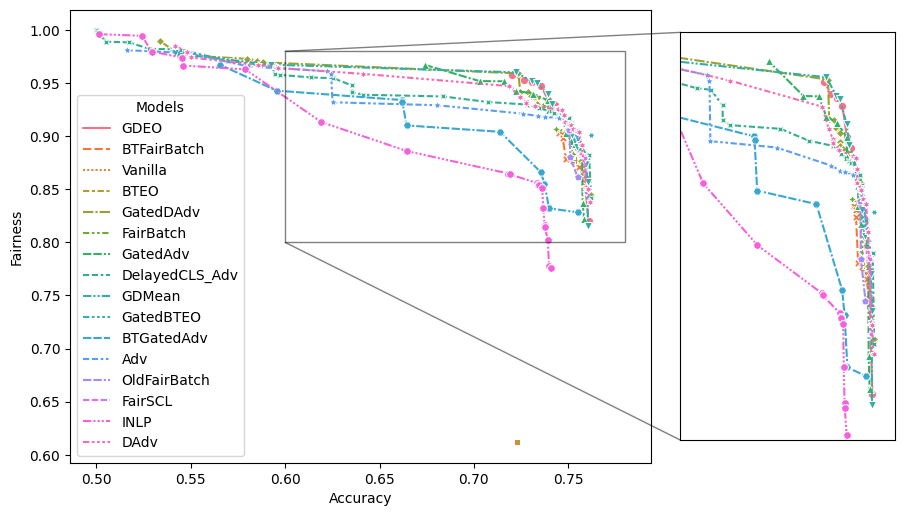

In [23]:
analysis.tables_and_figures.make_zoom_plot(
    Moji_plot_df, dpi = 100,
    zoom_xlim=(0.6, 0.78), 
    zoom_ylim=(0.8, 0.98),
    )

## 6. Cutomize pipeline for fairness

Check out the website [https://hanxudong.github.io/fairlib/](https://hanxudong.github.io/fairlib/) for detailed docs.

- Visualization
  - [Interactive plots](https://github.com/HanXudong/fairlib/blob/main/tutorial/interactive_plots.ipynb) demonstrates creating interactive plots for comparing different methods, and demonstrating DTO and constrained selection.
  - [Plot gallery](https://hanxudong.github.io/fairlib/tutorial_notebooks/tutorial_plot_gallery.html) presents a list of examples for presenting experimental results, e.g., hyperparameter tuning and trade-off plots with zoomed-in area.


- Customized Dataset and Models
  - [The dataset document](https://hanxudong.github.io/fairlib/tutorial_customized_datasets_and_dataloaders.html) provides instructions for customizing datasets and dataloaders.
  - [The model document](https://hanxudong.github.io/fairlib/tutorial_customized_models.html) provides instructions for customizing model architectures and register models.
  - Besides text inputs, we also provide examples for customizing datasets and models with [structured inputs](https://hanxudong.github.io/fairlib/tutorial_notebooks/tutorial_COMPAS.html) and [images](https://hanxudong.github.io/fairlib/tutorial_notebooks/tutorial_colored_MNIST.html).


- Customized Metrics
  - This [document](https://hanxudong.github.io/fairlib/tutorial_customized_evaluation.html) provides instructions for customizing evaluation metrics.
  - Single metric evaluations can be seen from [there](https://github.com/HanXudong/fairlib/blob/47f4b332e15ff8f22b238db6be983ec753fd2537/fairlib/src/evaluators/evaluator.py#L94).
  - Metric aggregations such as the default root mean square aggregation can be found from [there](https://github.com/HanXudong/fairlib/blob/47f4b332e15ff8f22b238db6be983ec753fd2537/fairlib/src/evaluators/evaluator.py#L75).


- Customized Debiasing Methods
  - [Please see the document](https://hanxudong.github.io/fairlib/tutorial_customized_methods.html) for instructions about adding method-specific options and integrating methods with *fairlib*.